In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch
import sys
sys.path.append('./..')
import cte
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from ProcessFunctions import find_Aisv2,Find_a_i,find_Aisv2_onlyv,Find_T_X_tau_without_p_input
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.interpolate import interp1d
import seaborn as sns 
from scipy import integrate
import scipy
import cte_eq

# Loading POD modes
T_final=10500
Ntout=cte_eq.Ntout
Nxout=cte_eq.Nxout
drs=0.012
mu=3e10

data_dir='/central/groups/Avouac_lab/hkaveh/Data/LearnROM/2D/MainSimulation2D_Tf'+str(T_final)+"Nt="+str(Ntout)+"Nx="+str(Nxout)+'PODonlyonV'+'drs'+str(drs)+".npz"
PODmodes=np.load(data_dir)
U_v=PODmodes['U']
S_v=PODmodes['S']
# VT_v=PODmodes['VT']
q_bar_v=PODmodes['q_bar']
Sigma_v=np.diagonal(S_v)
Nt2=127534 # This is the number os snapshots used to find the POD, it is fined in the RunForward2D.ipynb
Lambda_v=Sigma_v**2/Nt2 # Covariance matrix


data_dir='/central/groups/Avouac_lab/hkaveh/Data/LearnROM/2D/MainSimulation2D_Tf'+str(T_final)+"Nt="+str(Ntout)+"Nx="+str(Nxout)+'PODonlyontheta'+'drs'+str(drs)+".npz"
PODmodes=np.load(data_dir)
U_theta=PODmodes['U']
S_theta=PODmodes['S']
# VT_theta=PODmodes['VT']
q_bar_theta=PODmodes['q_bar']
Sigma_theta=np.diagonal(S_theta)
# Nt2=VT_theta.shape[0]
Lambda_theta=Sigma_theta**2/Nt2 # Covariance matrix
N_m_load=30
phi=U_v[:,:N_m_load]    # This contains the eigen mode for velocity


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [6]:
dt=6*3600          #                for SSEs I used             5*24*3600 
gamma_ratio=0.0001*5 # variance of the observation noise is multiplied by the value
sigma_kernel=2000 # in meters

N_m_v_list=[20,25,30]
N_m_theta_list=[20,25,30]
index=0
N_m_theta=N_m_theta_list[index]
N_m_v=N_m_v_list[index]

Lambda=np.append(Lambda_v[:N_m_v],Lambda_theta[:N_m_theta]) # Lambda is the covariance matrix
Lambda=np.diag(Lambda)

Gamma=np.diag(Lambda_v[:N_m_v])

t_yr=365*24*3600           # number of seconds in a year
Nx=1024
L_thresh=1e3
L=240e3
L_fault=L
x_ox=np.linspace(-L/2,L/2,Nx)
L_element_x=L/Nx

sigma_x=sigma_kernel/L_element_x # in number of elements

Obs_linear=0
inflation=1  # inflection of the model noise covariance matrix

In [7]:
print(L_element_x)
print(sigma_x)
print("for SSE example sigma_x was 1.6")

234.375
8.533333333333333
for SSE example sigma_x was 1.6


In [8]:
# defining the model noise as xi \in R^n which is a normal distribution with mean 0 and std proportional to Lambda,
# We take the covarinace matrix of the model noise (remember covariance as the unit standard deviation squared)
# Here covariance matrix is Sigma

# def xi_call2(Lambda,xi_ratio,m):
#     xi=np.random.multivariate_normal(np.zeros(Lambda.shape[0]),xi_ratio*Lambda,m)
#     return xi.T

def xi_call(N_m,cov,m):
    xi=np.random.multivariate_normal(np.zeros(N_m),cov,m)
    return xi.T

In [9]:
Gamma.shape

(20, 20)

In [10]:
# defining the observation noise as eta \in R^d which is a normal distribution with mean 0 and std proportional to Lambda_y,
def eta_call(Gamma,gamma_ratio,m):
    eta=np.random.multivariate_normal(np.zeros(Gamma.shape[0]),gamma_ratio*Gamma,m)
    return eta.T

In [11]:
# import the model from the code MLmodel8postprocess.ipynb
# %% Defining model (g_1)
class Forwardmap(nn.Module):
    def __init__(self, N_m, dropout_rate=0.2, negative_slope=0.01):
        super().__init__()
        self.hidden1 = nn.Linear(N_m, 2 * N_m)
        self.act1 = nn.LeakyReLU(negative_slope)
        self.hidden2 = nn.Linear(2 * N_m, 4 * N_m)
        self.act2 = nn.LeakyReLU(negative_slope)
        self.hidden3 = nn.Linear(4 * N_m, 4 * N_m)
        self.act3 = nn.LeakyReLU(negative_slope)
        self.hidden4 = nn.Linear(4 * N_m, 2 * N_m)
        self.act4 = nn.LeakyReLU(negative_slope)
        self.output = nn.Linear(2 * N_m, N_m)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.dropout(x)
        x = self.act2(self.hidden2(x))
        x = self.dropout(x)
        x = self.act3(self.hidden3(x))
        x = self.dropout(x)
        x = self.act4(self.hidden4(x))
        x = self.dropout(x)
        x = self.output(x)
        return x
version=0
    
model=Forwardmap(N_m_v+N_m_theta)
model.load_state_dict(torch.load(
    "/central/groups/astuart/hkaveh/Data/LearnROM/Earthquake2D_ROM_POD_separate_onV_theta"
    + str(version)
    + "N_m_v"
    + str(N_m_v)
    + "N_m_theta"
    + str(N_m_theta)
    + ".pt",
    map_location=torch.device('cpu')
))
model.eval()
model=model.to(device)

In [12]:
# The reduced order model for v is already loaded
# lets load the model for dt
# Loading the pytorch ML model
version_dt=0
class Forwardmapdt(nn.Module):
    def __init__(self,N_m_v, dropout_rate=0.2, negative_slope=0.01):
        super().__init__()
        self.hidden1=nn.Linear(N_m_v+1,2*N_m_v)
        self.act1=nn.LeakyReLU(negative_slope)
        self.hidden2=nn.Linear(2*N_m_v,4*N_m_v)
        self.act2=nn.LeakyReLU(negative_slope)
        self.hidden3=nn.Linear(4*N_m_v,4*N_m_v)
        self.act3=nn.LeakyReLU(negative_slope)
        self.hidden4=nn.Linear(4*N_m_v,2*N_m_v)
        self.act4=nn.LeakyReLU(negative_slope)
        self.output=nn.Linear(2*N_m_v,1)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self,x):
        x=self.act1(self.hidden1(x))
        x = self.dropout(x)
        x=self.act2(self.hidden2(x))
        x = self.dropout(x)
        x=self.act3(self.hidden3(x))
        x = self.dropout(x)
        x=self.act4(self.hidden4(x))
        x = self.dropout(x)
        x=(self.output(x))
        return x
    
modeldt=Forwardmapdt(N_m_v)
modeldt.load_state_dict( torch.load("/central/groups/Avouac_lab/hkaveh/Data/LearnROM/2D/EQ_ROM_g2"+str(version)+"N_m_v"+str(N_m_v)+".pt"))
modeldt.eval()
modeldt=modeldt.to(device)


In [13]:

phi_torch     = torch.tensor(phi[:,:20], dtype=torch.float32, device=device)
q_bar_v_torch = torch.tensor(q_bar_v, dtype=torch.float32, device=device)

def find_logvmax(alpha):
    if not isinstance(alpha, torch.Tensor):
        alpha = torch.tensor(alpha, dtype=phi_torch.dtype, device=phi_torch.device)
    v = torch.matmul(phi_torch, alpha).unsqueeze(1) + q_bar_v_torch
    logvmax = torch.max(v).detach()  # Get the maximum value in v
    return logvmax

In [15]:
params_f=[N_m_v+N_m_theta]
rho=2
lambda_dissipation=0.1

In [16]:
def dissipation_factor(xk,rho,Sigma,Beta=20):
    # u=xk/Sigma # normalize by the std
    alpha=xk[:,:N_m_v]
    logvmax=find_logvmax(alpha.T)
    # norm_u=torch.norm(u)
    output=1/(1+torch.exp(Beta*(logvmax-rho)))
    return output
directory='/central/groups/Avouac_lab/hkaveh/Data/LearnROM/2D/sigma'+str(T_final)+"Nt="+str(Ntout)+"Nx="+str(Nxout)+'PODonlyonV'+'drs'+str(drs)+".npz"
Sigma_v=np.load(directory)['Sigma_v']
Sigma_theta=np.load(directory)['Sigma_theta']
Sigma=np.concatenate((Sigma_v,Sigma_theta))
Sigma = torch.tensor(Sigma, dtype=torch.float32, device=device)

In [17]:
# This function is written to find the next time step in the Kalman filter algorithm and is the forward model
# This function needs to be double checked.
def f(alpha_k,dt,params_f):
    # alpha_k is the state at time k
    # alpha_kp1 is the state at time k+1
    # dt is the time step (assume in seconds)
    N_m=params_f[0]
    xk=torch.tensor(alpha_k, dtype=torch.float32)           # xk is in torch.
    forecast=xk.detach().cpu().numpy().reshape(N_m,1)       # forecast is in cpu.
    time=np.array([0])                                      # time is in cpu
    while time[-1]<dt:
        xk=xk.to(device,dtype=torch.float32)
        dissipate=dissipation_factor(xk.reshape((1,N_m)),rho,Sigma)          # torch
        ykp1=(model(xk))                                    # ykp1 is the prediction of the model in torch
        xkp1=(ykp1+xk)* dissipate + (1-dissipate)*(lambda_dissipation*xk) # This is the prediction of the model in torch

        numpy_vector = xkp1.detach().cpu().numpy().reshape(N_m,1)
        x_ML=numpy_vector                             # This is the alpha that has both v and theta
        vmax=find_logvmax(x_ML[:N_m_v])       # This is the maximum of v

        x_input_dt_ML=x_ML[:N_m_v]                 # This is the input for the dt model (except vmax)
        x_input_dt_ML=np.append(x_input_dt_ML,vmax.detach().cpu().numpy())         # This is the input for the dt model
        x_input_dt_ML=torch.tensor(x_input_dt_ML, dtype=torch.float32) # This is the input for the dt model
        x_input_dt_ML=x_input_dt_ML.to(device)
        dt_pred=modeldt(x_input_dt_ML)                      # This is the prediction for the time step
        dt_pred=10 ** dt_pred.detach().cpu().double().numpy().astype(np.float64)    # This is the prediction for the time step
        time=np.append(time,dt_pred+time[-1])                        # This is the time vector
        forecast = np.hstack([forecast, numpy_vector])      # This is the forecasted alpha (not scaled though)
        xk=xkp1
    
    # applying linear interpolation to find forecast at time dt, using only the last two points
    f2 = interp1d([time[-2],time[-1]], forecast[:,-2:],axis=1)
    alpha_kp1=f2(dt).reshape(N_m,1)
    # Removing the last coulmn of forecast becasue it is for the time when t > dt
    forecast=forecast[:,:-1]
    time[-1]=dt
    # Then appending it to the forecast
    forecast = np.concatenate((forecast, alpha_kp1),axis=1)
    return forecast,time


# Find The Scaling and check if it makes sense

In [18]:
# # This cell runs the program for up to time t_test
t_test=200*24*3600*365
# t_test=10
# size_x=256
# size_y=32
# size=U_v.shape[0]
# specify random seed
np.random.seed(0)
alpha_k=xi_call(40,Lambda,1).T
forecast,time=f(alpha_k,t_test,params_f)

: 

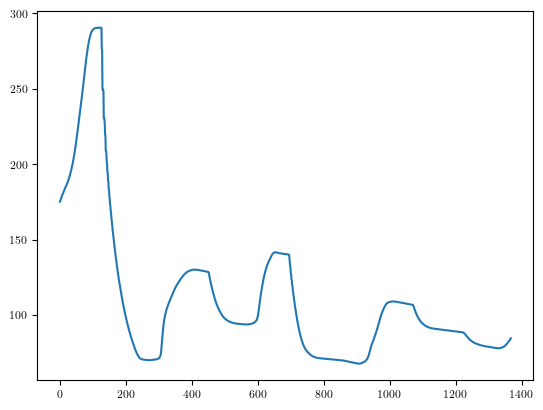

In [ ]:
plt.plot(forecast[0,:])

In [ ]:
N_it=forecast.shape[1]

In [ ]:
L

240000.0

In [ ]:
delta_x=L/Nx

In [ ]:
def findscalingquantities(pdot,t,v,delta_x,V_event=1e-2): 
    flag_event=False
    T1s=[] # this is the time of the start of events
    T2s=[] # this is the time of the end of events
    length_ruptures=[] # this is the length of the rupture
    pots=[] # integral of pdot over the event duration

    for i in range(v.shape[0]): # first dimension is time
        if np.max(v[i,:])>V_event and flag_event==False:
            start=i
            T1s.append(t[i,0])
            flag_event=True
            print(i)
        if np.max(v[i,:])<V_event and flag_event==True:
            end=i
            flag_event=False
            T2s.append(t[i,0])
            print(i)
            # check from start to end for all elements of v[start,:] to v[end,:] which elements had v >v_event in one line, from this you can find the event extent
            ruptured=np.where(v[start:end,:]>V_event,1,0)
            # find the locations at which at least there is one element that is ruptured
            ruptured=np.sum(ruptured,axis=0)
            ruptured=(ruptured>0)
            # summing number of ruptured elements
            num_ruptured_elements=np.sum(ruptured)
            # then the rupture length of this event is given by 
            length_rupture=num_ruptured_elements*delta_x
            length_ruptures.append(length_rupture)
            potency_of_event=integrate.cumtrapz(pdot[start:end],t[start:end,0])  
            print(potency_of_event[-1])  
            pots.append(potency_of_event[-1])
    return  T1s,T2s,length_ruptures,pots

In [ ]:
def Gut(Mw,NpointsM=30):
    CumNumber=np.array([])
    c1=np.min(Mw)
    c2=np.max(Mw)-.0001 # To remove log10(0) error
    # print(c1)
    # print(c2)
    c=np.linspace(c1,c2,NpointsM)
    # print(c)
    for i in range(c.size):
        CumNumber=np.append(CumNumber,(sum(j > c[i] for j in Mw)))
    return c,CumNumber 

In [ ]:
find_scaling=True

In [ ]:
size_x=U_v.shape[0]
V_ox_ROM=np.empty((N_it+1,size_x))
t_ox_ROM=np.ones((N_it+1,size_x))
vmax=[]
U_ROM=U_v[:,0:N_m_v]
for j in range(N_it):
    V_snapshot = U_ROM @ (forecast[:N_m_v,j]) + q_bar_v.reshape(size_x,)
    vmax.append(np.max(V_snapshot))
    V_ox_ROM[j,:]=10**(V_snapshot)
    t_ox_ROM[j,:]=time[j]*np.ones((1,size_x))
if find_scaling:    
    pdot=np.sum(V_ox_ROM,axis=1)*delta_x

    T1s_ROM,T2s_ROM,length_ruptures_ROM,pots_ROM=findscalingquantities(pdot,t_ox_ROM,V_ox_ROM,delta_x,V_event=1e-3)
    T1s_ROM=np.array(T1s_ROM)
    T2s_ROM=np.array(T2s_ROM)
    length_ruptures_ROM=np.array(length_ruptures_ROM)
    pots_ROM=np.array(pots_ROM)
    moment_ROM=mu*pots_ROM
    log_10_moment_events_ROM=np.log10(moment_ROM)
    mags_ROM,cumN_ROM=Gut(log_10_moment_events_ROM)
    # if len(T2s_ROM) == len(T1s_ROM) - 1:
    #     T1s_ROM = T1s_ROM[:-1]


111
296
27701.578986020944
419
575
22946.8081057949
671
917
29015.18267571831
1027
1339
29082.400445745552


In [ ]:
pdot[427]

29.82914798246506

In [ ]:
pdot[572]

23.65501863192654

In [ ]:
time[427]

63207660.010643974

In [ ]:
time[572]

63207669.63503714

In [ ]:
T1s_ROM

array([7.14393141e+02, 6.32076584e+07, 1.09206797e+09, 1.54290708e+09])

In [ ]:
T2s_ROM

array([7.28232982e+02, 6.32076721e+07, 1.09206799e+09, 1.54290710e+09])

In [ ]:
print(length_ruptures_ROM)

[ 8671.875  8671.875 12187.5   13828.125]


In [ ]:
print(pots_ROM)

[27701.57898602 22946.80810579 29015.18267572 29082.40044575]


In [ ]:
moment_ROM

array([8.31047370e+14, 6.88404243e+14, 8.70455480e+14, 8.72472013e+14])

In [ ]:
pdot

array([ 3.09426415e-03,  3.02476854e-03,  2.95815638e-03, ...,
        1.98893207e-04,  1.96887805e-04, -7.06382204e+10])

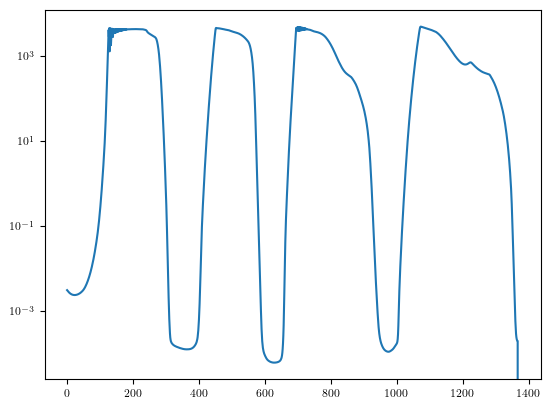

In [ ]:
plt.plot(pdot)
plt.yscale("log")

In [ ]:
T_final_ROM=time[-1]/cte.t_yr
print(T_final_ROM)

49.96714489103056


/central/groups/astuart/hkaveh/soft/miniconda3/envs/learnmodel/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  # This is added back by InteractiveShellApp.init_path()
/central/groups/astuart/hkaveh/soft/miniconda3/envs/learnmodel/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  
/central/groups/astuart/hkaveh/soft/miniconda3/envs/learnmodel/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.


Text(0.5, 1.0, 'dissipate with: 0.1')

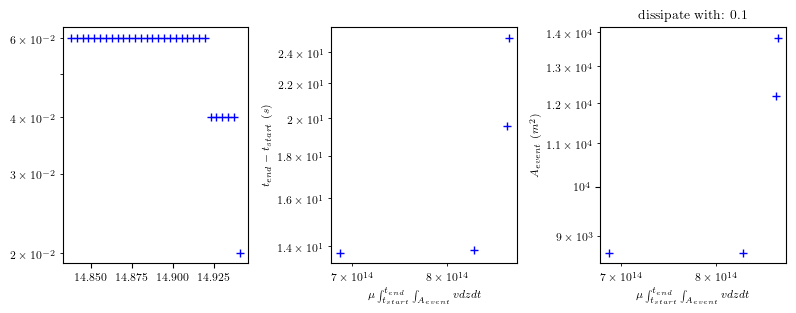

In [ ]:
# make a figure with
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'text.usetex': True,  # If you want to use LaTeX for rendering text
})
fig, axs = plt.subplots(1, 3, figsize=(8, 3))

plt.rcParams.update({'font.family': 'serif', 'font.serif': 'Times New Roman','font.size': 8})

axs[0].plot(mags_ROM, cumN_ROM/T_final_ROM, '.',color='blue',label='ROM',marker='+')
# axs[0].plot(mags, cumN/(number_to_load*T_final_run), '.', color='black',label="ROM")
axs[0].set_yscale("log")
# plotting in loglog scale the length of events in y axis and moment in x axis

axs[1].plot(moment_ROM, T2s_ROM-T1s_ROM ,  '.', color='blue',label="ROM",marker="+")
# axs[1].plot(moment_events, T2s_all-T1s_all ,  '.', color='black',label='PDE')

axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r"$\mu \int_{t_{start}}^{t_{end}} \int_{A_{event}} v dz dt$")
axs[1].set_ylabel(r"$t_{end}-t_{start}$ $(s)$")

axs[2].plot(moment_ROM, length_ruptures_ROM ,  '.', color='blue',label="ROM",marker="+")
# axs[2].plot(moment_events, length_ruptures_all , '.', color='black',label="PDE")

axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel(r"$\mu \int_{t_{start}}^{t_{end}} \int_{A_{event}} v dz dt$")
axs[2].set_ylabel(r"$A_{event}$ ($m^2$)")
plt.tight_layout()
plt.title("dissipate with: "+
str(lambda_dissipation))
#
# plt.savefig("dissipate with: "+str(lambda_dissipation)+"rho"+str(rho)+".png")

so far, we have I have written the code to find the ROM and the scaling that I get is reasonable close to the original scaling



To do:
* find the model noise

In [ ]:
moment_ROM

array([8.31047370e+14, 6.88404243e+14, 8.70455480e+14, 8.72472013e+14])